In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

import utils

mnist_path = 'data/mnist-zoomed-to-bounds.npy'
model_path = 'data/model'

2021-07-03 20:03:42.107854: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

2021-07-03 20:03:42.976356: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1


[]

2021-07-03 20:03:46.924272: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-03 20:03:46.924409: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dell-taco): /proc/driver/nvidia/version does not exist


In [3]:
# Use cached augmented data if it exists
if os.path.isfile(mnist_path) is False:
    print("Normalizing mnist data set")
    mnist = tf.keras.datasets.mnist

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train / 255.0
    x_test  = x_test  / 255.0
    
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test  = x_test.reshape(x_test.shape[0], 28, 28, 1)

    x_train = np.array([utils.zoom_to_bounds(img_array) for img_array in x_train])
    x_test  = np.array([utils.zoom_to_bounds(img_array) for img_array in x_test])

    to_save =  np.array( ([x_train, y_train], [x_test, y_test]) )
    np.save(mnist_path, to_save)
else:
    print("Using cached mnist data set")
    (x_train, y_train), (x_test, y_test) = np.load(mnist_path, allow_pickle=True)

Using cached mnist data set


In [4]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [6]:
# Not overwriting if already exists!
if os.path.isdir(model_path) is False:
    print("Training model")
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10)
    ])
    model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=12)
    model.save(model_path)
else:
    print("Loading cached model")
    model = tf.keras.models.load_model(model_path)
    
model.evaluate(x_test,  y_test, verbose=2)

Loading cached model


2021-07-03 20:05:28.364279: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-03 20:05:28.661294: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-03 20:05:28.680807: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199995000 Hz


313/313 - 0s - loss: 0.0782 - accuracy: 0.9773


[0.07823777198791504, 0.9772999882698059]

In [7]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [8]:
pngs = sorted(glob("data/pngs/*.png"))
def load_image(path):
    image     = tf.keras.preprocessing.image.load_img(path, color_mode="grayscale", target_size=(28,28), interpolation='nearest')
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    return input_arr / 255

actual_data = [load_image(png) for png in pngs]
actual_data = np.array(actual_data)
actual_data.shape

(37, 28, 28, 1)

/tmp/ipykernel_63836/2132475441.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))


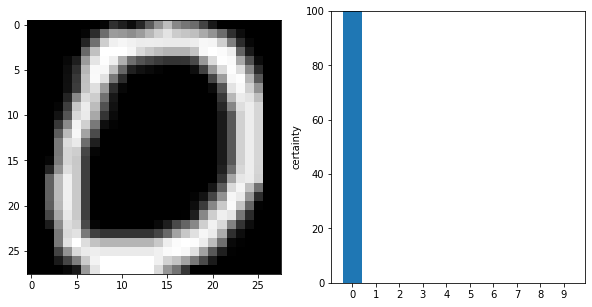

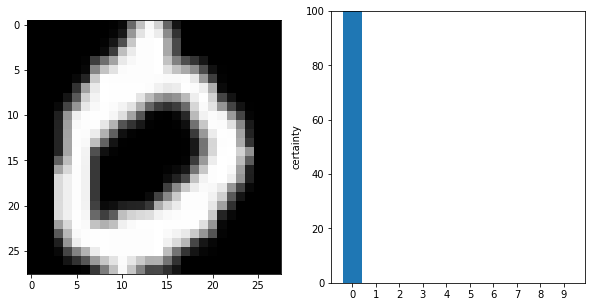

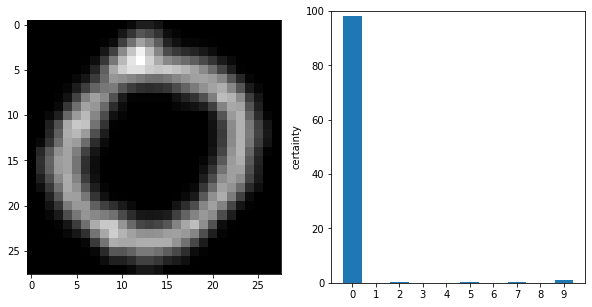

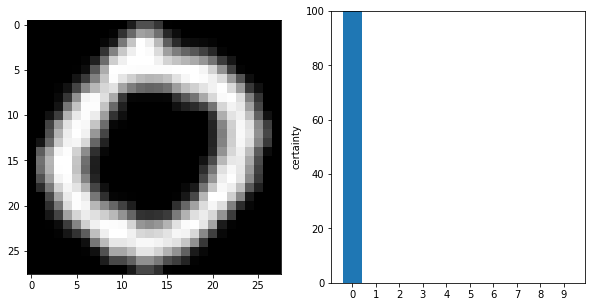

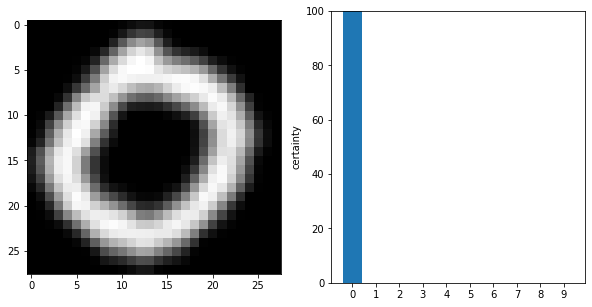

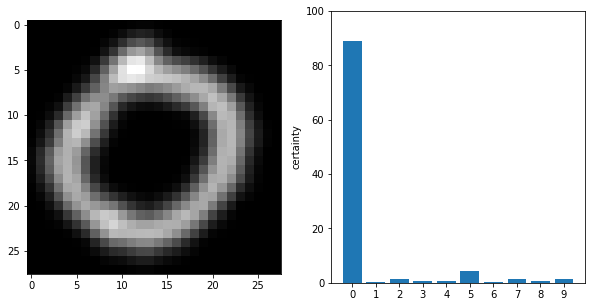

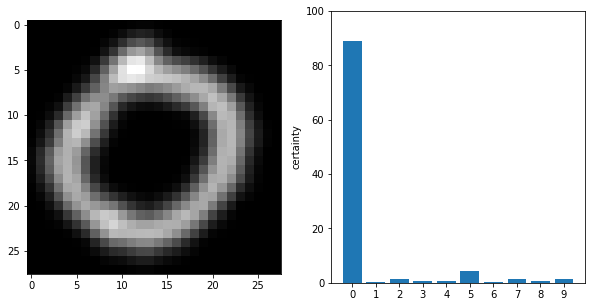

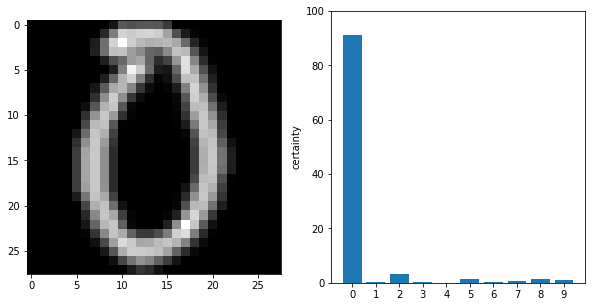

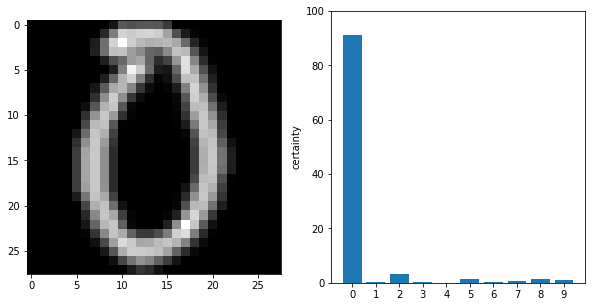

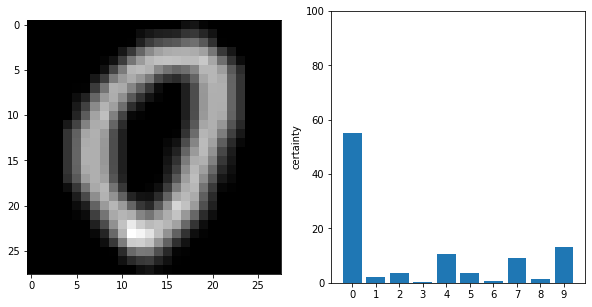

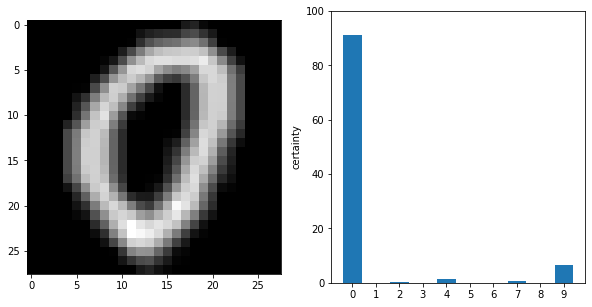

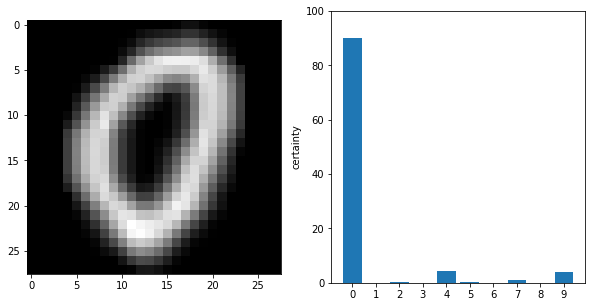

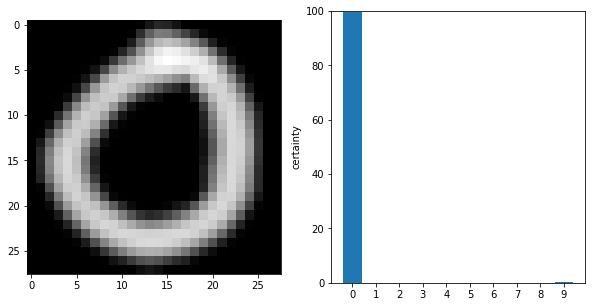

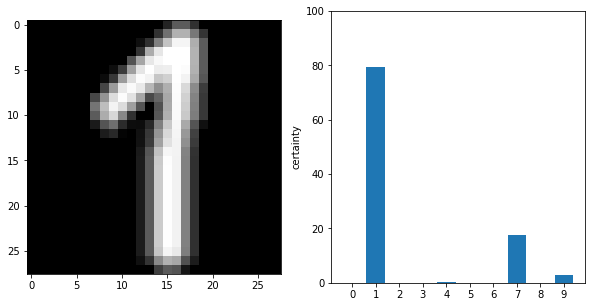

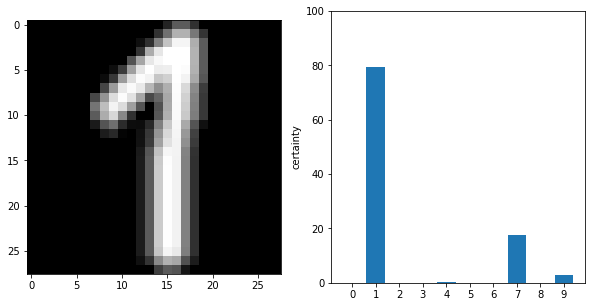

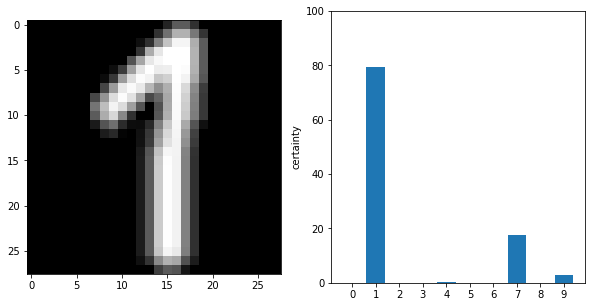

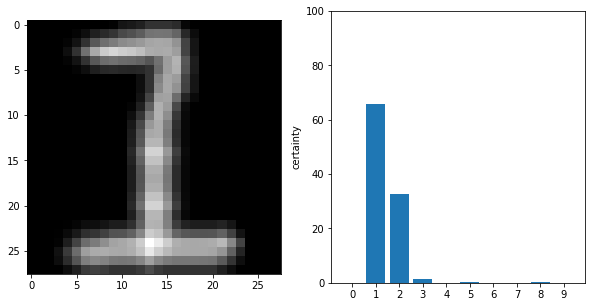

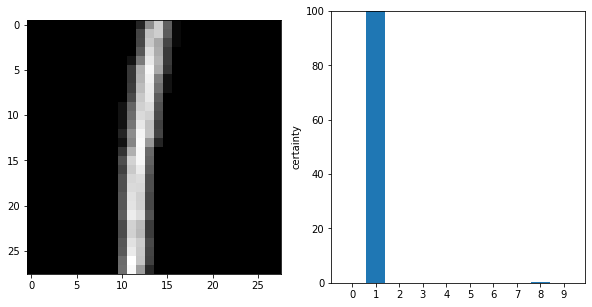

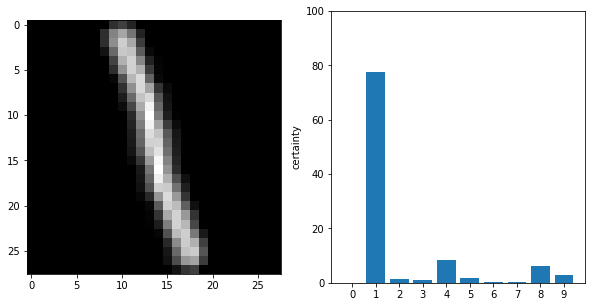

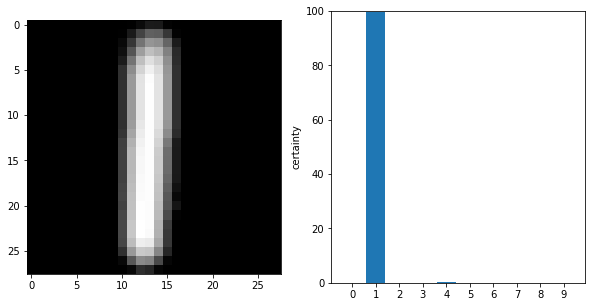

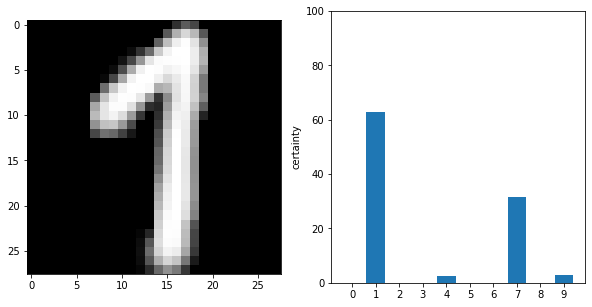

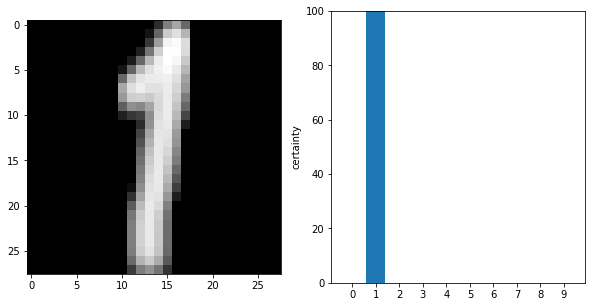

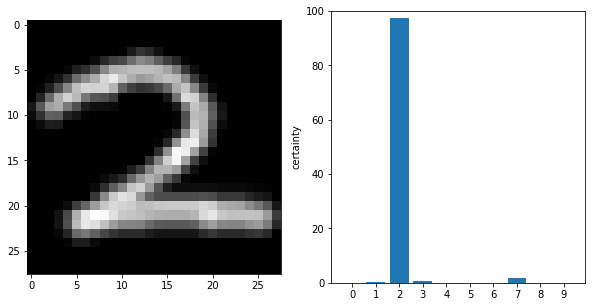

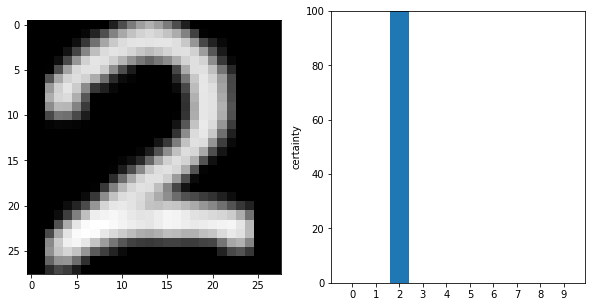

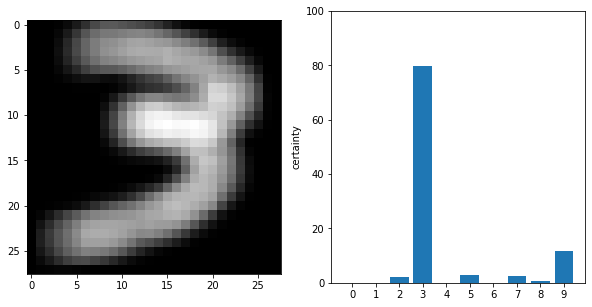

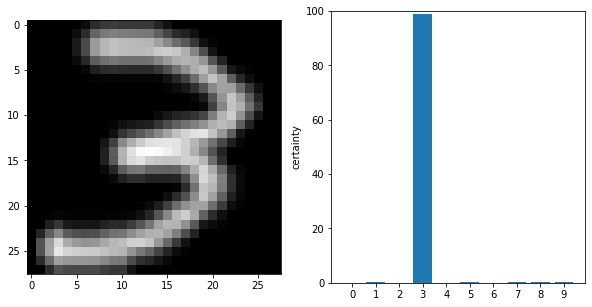

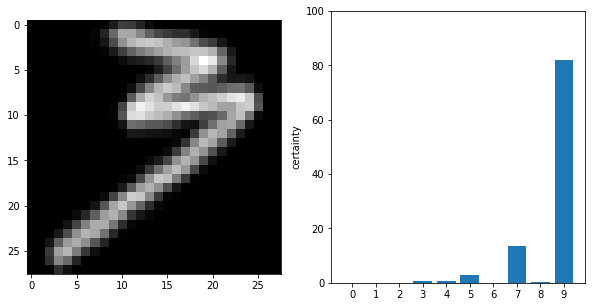

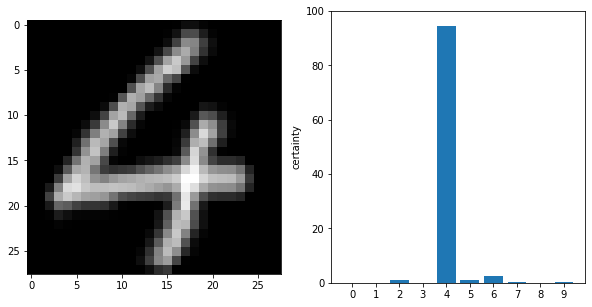

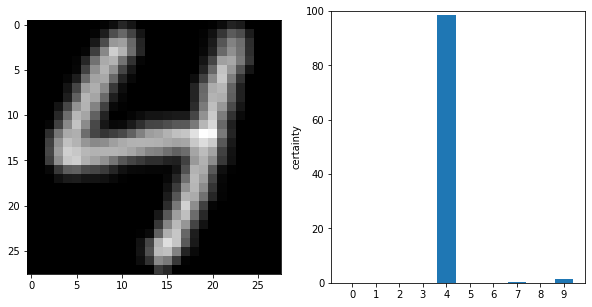

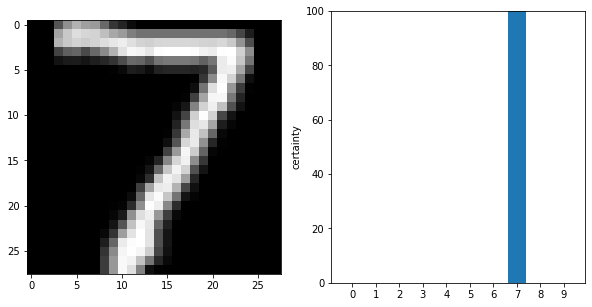

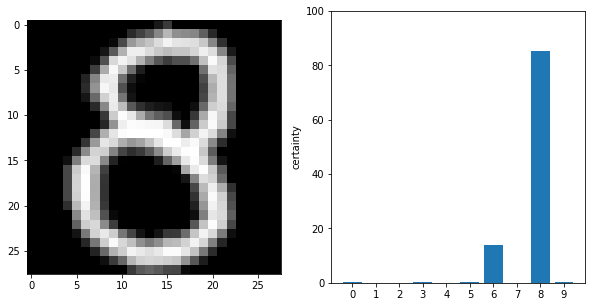

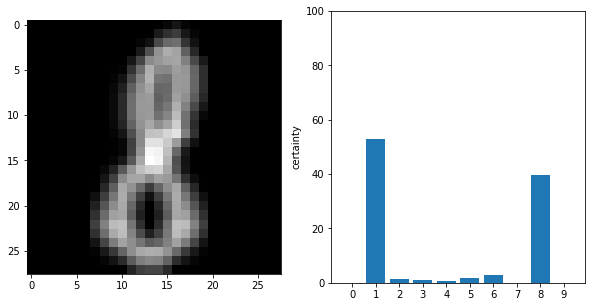

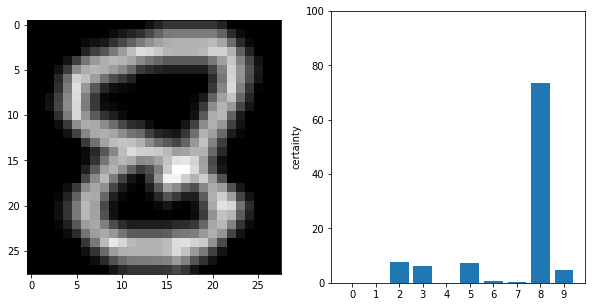

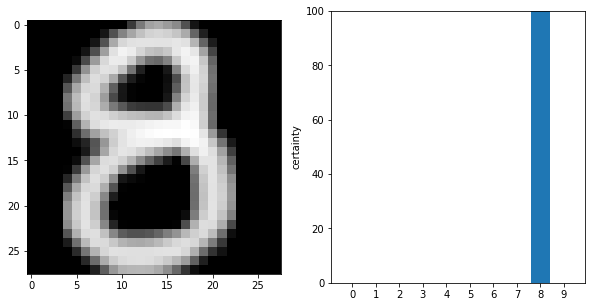

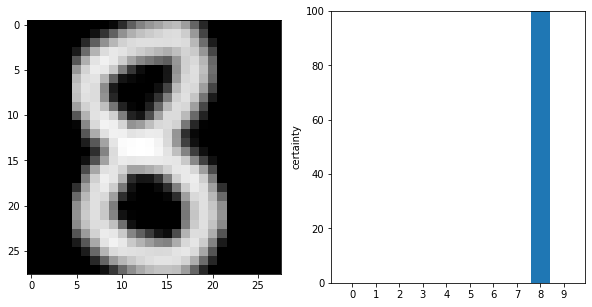

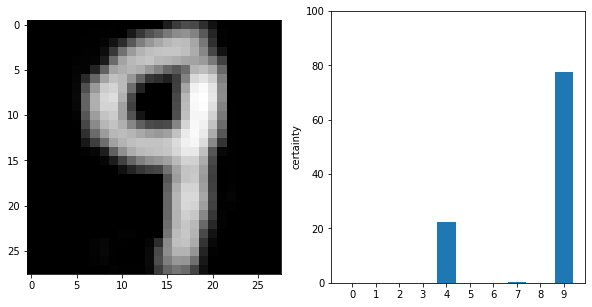

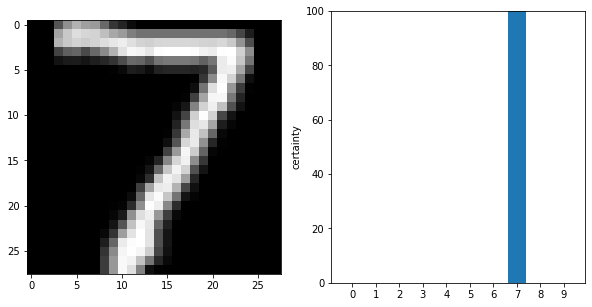

In [9]:
data = np.array([utils.zoom_to_bounds(img_array) for img_array in actual_data[:100]])
predictions = probability_model(data) * 100
for i, d in enumerate(data):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.imshow(d, cmap="gray")
    ax2.bar(x=range(0, 10), height=predictions[i], tick_label=range(0, 10))
    ax2.set(ylabel="certainty", ylim=(0, 100))
